In [8]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from math import sqrt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [10]:

df = pd.read_csv('MSN Historical Data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1249 non-null   object 
 1   Price     1249 non-null   float64
 2   Open      1249 non-null   float64
 3   High      1249 non-null   float64
 4   Low       1249 non-null   float64
 5   Vol.      1249 non-null   float64
 6   Change %  1249 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.4+ KB


In [11]:

dataset=df.loc[:,["Date","Price"]]
dataset.tail()

,Date,Price
1244,11/25/2022,94000.0
1245,11/28/2022,97200.0
1246,11/29/2022,99000.0
1247,11/30/2022,102000.0
1248,12/1/2022,99000.0


In [12]:
dataset.head()

,Date,Price
0,12/1/2017,68500.0
1,12/4/2017,69000.0
2,12/5/2017,68900.0
3,12/6/2017,67700.0
4,12/7/2017,69000.0


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1249 non-null   object 
 1   Price   1249 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.6+ KB


In [14]:
dataset.describe()

,Price
count,1249.000000
mean,84948.191353
std,23451.518390
min,39997.000000
25%,72915.000000
50%,84200.000000
75%,100924.000000
max,142286.000000


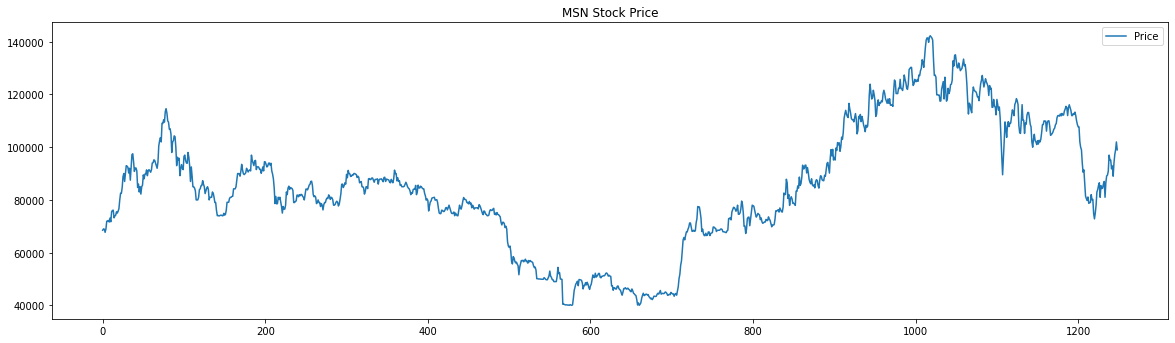

In [15]:
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
plt.title('MSN Stock Price')
plt.plot(df.Price,label='Price')
plt.legend()


In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df['Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.595643
p-value                    0.485782
# lags used               15.000000
# observations          1233.000000
critical value (1%)       -3.435665
critical value (5%)       -2.863887
critical value (10%)      -2.568020
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [18]:
auto_arima(df['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(4, 1, 0)   Log Likelihood              -11303.552
Date:                Wed, 04 Jan 2023   AIC                          22617.105
Time:                        23:40:25   BIC                          22642.751
Sample:                             0   HQIC                         22626.747
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0497      0.018      2.823      0.005       0.015       0.084
ar.L2         -0.0028      0.022     -0.127      0.899      -0.046       0.041
ar.L3         -0.0651      0.019     -3.460      0.001      -0.102      -0.028
ar.L4          0.0662      0.018      3.645      0.000       0.031       0.102
sigma2      4.307e+06   1.19e+05     36.235      0.000    4.07e+06    4.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               284.75
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[Text(0, 0.5, 'Stock Price'), Text(0.5, 0, '')]

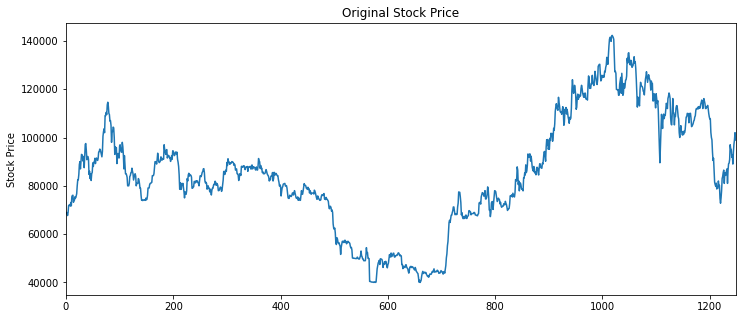

In [19]:
title = 'Original Stock Price'
ylabel='Stock Price'
xlabel='' # we don't really need a label here

ax = df['Price'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [20]:
auto_arima(df['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(4, 1, 0)   Log Likelihood              -11303.552
Date:                Wed, 04 Jan 2023   AIC                          22617.105
Time:                        23:40:55   BIC                          22642.751
Sample:                             0   HQIC                         22626.747
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0497      0.018      2.823      0.005       0.015       0.084
ar.L2         -0.0028      0.022     -0.127      0.899      -0.046       0.041
ar.L3         -0.0651      0.019     -3.460      0.001      -0.102      -0.028
ar.L4          0.0662      0.018      3.645      0.000       0.031       0.102
sigma2      4.307e+06   1.19e+05     36.235      0.000    4.07e+06    4.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               284.75
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df['d1'],'Stock Price')

Augmented Dickey-Fuller Test: Stock Price
ADF test statistic     -9.131405e+00
p-value                 3.015114e-15
# lags used             1.400000e+01
# observations          1.233000e+03
critical value (1%)    -3.435665e+00
critical value (5%)    -2.863887e+00
critical value (10%)   -2.568020e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


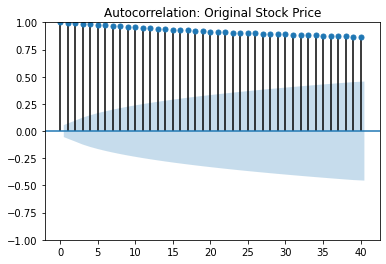

In [22]:
title = 'Autocorrelation: Original Stock Price'
lags = 40
plot_acf(df['Price'],title=title,lags=lags);

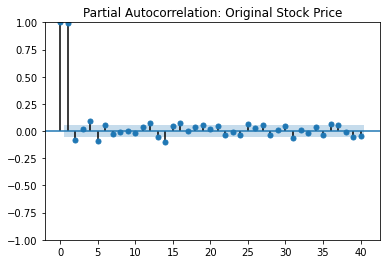

In [23]:
title = 'Partial Autocorrelation: Original Stock Price'
lags = 40
plot_pacf(df['Price'],title=title,lags=lags);

In [24]:
stepwise_fit = auto_arima(df['Price'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22630.427, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22628.778, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22628.749, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22628.598, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22630.749, Time=2.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.807 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -11313.299
Date:                Wed, 04 Jan 2023   AIC                          22628.598
Time:                        23:41:00   BIC                          22633.727
Sample:                             0   HQIC                         22630.526
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.376e+06   1.18e+05     37.178      0.000    4.15e+06    4.61e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):               309.23
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [26]:
def split_data(data, test_split):
    length = len(data)
    size = round(length * (1 - test_split))
    train, test = data[:size], data[size:]
    print('train:', len(train))
    print('test:', len(test))
    return train, test

In [27]:
test_split = 0.3
train, test = split_data(df, test_split)

train: 874
test: 375


In [28]:
model = sm.tsa.arima.ARIMA(train['Price'], order = (0,1,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  874
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7730.545
Date:                Wed, 04 Jan 2023   AIC                          15463.089
Time:                        23:41:00   BIC                          15467.861
Sample:                             0   HQIC                         15464.915
                                - 874                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.874e+06   8.21e+04     34.994      0.000    2.71e+06    3.04e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               479.55
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start = len(train)
end = len(train) + len(test) -1
pred = model.predict(start = start, end = end, typ = 'levels').rename('ARIMA(0,1,0) Predictions')

print(pred)
pred.index = df.index[start: end + 1]

874     85710.0
875     85710.0
876     85710.0
877     85710.0
878     85710.0
         ...   
1244    85710.0
1245    85710.0
1246    85710.0
1247    85710.0
1248    85710.0
Name: ARIMA(0,1,0) Predictions, Length: 375, dtype: float64


[Text(0, 0.5, 'Stock Price'), Text(0.5, 0, '')]

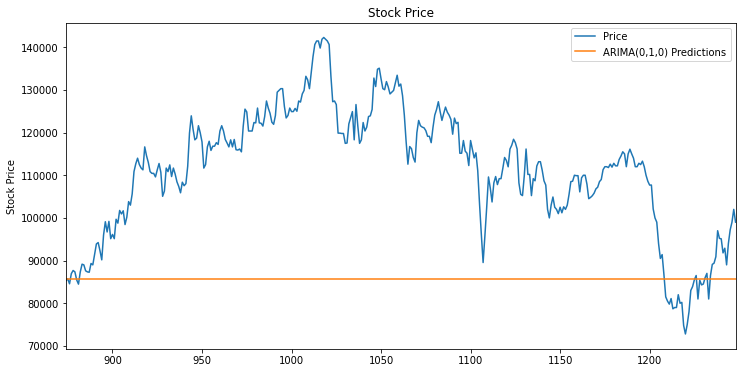

In [30]:
# Plot predictions against known values
title = 'Stock Price'
ylabel='Stock Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
pred.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse =  mean_squared_error(pred, test['Price'])
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(pred, test['Price'])
print("RMSE: ", rmse)
print("MAPE: ", mape * 100)

RMSE:  29316.106501466616
MAPE:  30.415220316571386
